In [25]:
import pandas as pd
import ete3
import re
import community
import networkx as nx
import itertools
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
import igraph as ig
import plotly
import chart_studio.plotly as ptl
import plotly.graph_objects as go
import colorlover as cl
from IPython.display import HTML
import multiprocessing
import pickle as pkl
import random
from sklearn import mixture
import os

ptl.sign_in('lthiberiol', 'm15ikp59lt')
ncbi = ete3.NCBITaxa()
%cd /work/eggNOG/

/work/eggNOG


In [2]:
sampled_genomes = pd.read_csv('/work/kelsey/genomes.tab',
                              sep='\t',
                              index_col=0)

In [3]:
lineages = pd.DataFrame()
for taxid in sampled_genomes.species_taxid.unique():
    if pd.isna(taxid):
        continue
    lineages = lineages.append({tax_rank: tmp_taxid 
                                 for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()},
                                ignore_index=True)
lineages = lineages.reindex(columns=['class', 'family',  'genus', 'phylum',
                                     'order', 'species', 'superkingdom']).copy()
lineages = lineages.query('superkingdom == 2').copy()

In [4]:
eggNOG_sample = pd.read_csv('e5.bacteria.taxid_info.tsv',
                            sep='\t',
                            comment='#',
                            names=['Taxid', 'Sci.Name', 'Rank', 'Named Lineage', 'Taxid Lineage'],
                            header=None,
                            index_col=0)

In [5]:
eggNOG_lineage = pd.DataFrame()
for taxid in eggNOG_sample.index.unique():
    if pd.isna(taxid):
        continue
    tmp = pd.Series({tax_rank: tmp_taxid 
                     for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()})
    tmp.name = taxid
    eggNOG_lineage = eggNOG_lineage.append(tmp)

eggNOG_lineage = eggNOG_lineage.reindex(columns=['class', 'family',  'genus', 'phylum',
                                                 'order', 'species', 'superkingdom']).copy()
eggNOG_lineage = eggNOG_lineage.query('superkingdom == 2').copy()

eggNOG_target_phyla = eggNOG_lineage[eggNOG_lineage.phylum.isin(lineages.phylum.unique())]

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1344012 was translated into 480813

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 443255 was translated into 1901

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1525715 was translated into 1545044

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 861530 was translated into 29382

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1317118 was translated into 1379903

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 67281 was translated into 67351

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/

In [6]:
eggNOG_groups = pd.read_csv('2_members.tsv',
                            sep='\t',
                            header=None,
                            usecols=[1,2,3,4],
                            names=['group_id', 'num_proteins', 'num_taxa', 'members'])

tmp           = eggNOG_groups.members.map(lambda cell: [int(taxid) 
                                                        for taxid in re.findall('(\d+)\.(?:[^,]+)', cell)])
tmp.name      = 'taxa'
eggNOG_groups = eggNOG_groups.join(tmp)

In [7]:
def get_phyla_overlap(taxa):
    #taxids = [int(_) for _ in taxa]
    group_phyla = set(eggNOG_lineage.loc[taxa, 'phylum'].unique())
    overlapped_phyla = group_phyla.intersection(lineages.phylum.unique())
    return(overlapped_phyla)

eggNOG_target_groups = eggNOG_groups[eggNOG_groups.taxa.map(lambda cell: 
                                                            True if len(get_phyla_overlap(cell)) > 1 
                                                            else False)]

In [8]:
eggNOG_trees = pd.read_csv('2_trees.tsv',
                           sep='\t',
                           header=None,
                           usecols=[1,2,3],
                           index_col=0,
                           names=['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=eggNOG_target_groups.group_id)

In [9]:
def get_patristic_distances(group_id):
    tree = ete3.Tree(eggNOG_trees.loc[group_id, 'tree'])
    
    edge_data = []
    for node in tree.traverse():
        if node.is_leaf():
            continue
        
        child1, child2 = node.get_children()
        child1_distance_to_root = pd.Series(index=child1.get_leaf_names(),
                                            data =[node.get_distance(leaf)
                                                   for leaf in child1.get_leaves()])
        child2_distance_to_root = pd.Series(index=child2.get_leaf_names(),
                                            data =[node.get_distance(leaf)
                                                   for leaf in child2.get_leaves()])

        for leaf1, leaf2 in itertools.product(child1_distance_to_root.index,
                                              child2_distance_to_root.index):
            edge_data.append([leaf1,
                               leaf2,
                               child1_distance_to_root[leaf1] + child2_distance_to_root[leaf2]])
    
    tmp_df = pd.DataFrame(columns=['leaf1', 'leaf2', 'distance'],
                          data   =edge_data)

    iiq = np.percentile(tmp_df.distance, 75) - np.percentile(tmp_df.distance, 25)
    tmp_df['standardized_distance'] = (tmp_df.distance - tmp_df.distance.median()) / iiq
    
    return(tmp_df)
#%timeit edges = get_patristic_distances(eggNOG_trees.loc['2Z7HP', 'tree'])
#1.04 s ± 4.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [28]:
def get_std_patristic_distances(group_id):
    tree = ete3.Tree(eggNOG_trees.loc[group_id, 'tree'])

    leaf_names = []
    for count, node in enumerate(tree.traverse()):
        if node.is_leaf():
            leaf_names.append(node.name)
        else:
            node.name = 'node_%i' % count

    edges = []
    for node in tree.traverse():
        if not node.is_leaf():
            for child in node.get_children():
                edges.append((node.name, child.name, child.dist))

    graph  = ig.Graph.TupleList(edges=edges, directed=False, weights=True)
    matrix = np.array(graph.shortest_paths(source=leaf_names, target=leaf_names, weights='weight'))

    taxids = [int(leaf.split('.')[0]) for leaf in leaf_names]
    phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

    triu_indices   = np.triu_indices_from(matrix, k=1)
    df = pd.DataFrame()
    df['phylum1']  = phyla[triu_indices[0]]
    df['phylum2']  = phyla[triu_indices[1]]
    df['distance'] = matrix[triu_indices]
    
    intra_phylum_df = df.loc[df.phylum1==df.phylum2]
    intra_phylum_df = intra_phylum_df[intra_phylum_df.phylum1!=1224]
    
    inter_phylum_df      = df[df.phylum1!=df.phylum2]
    cyano_VS_chloroflexi = inter_phylum_df.loc[(inter_phylum_df.phylum1.isin([200795, 1117])) & \
                                               (inter_phylum_df.phylum2.isin([200795, 1117])),
                                               'distance'].values
    
    with open('chloroflexi_cyano_dists/%s.pkl' % group_id, 'wb') as out:
        pkl.dump(cyano_VS_chloroflexi/intra_phylum_df.distance.median(), out)

    return(group_id)

In [29]:
get_std_patristic_distances('COG0499')

'COG0499'

In [11]:
eggNOG_chloroflexi = eggNOG_lineage.query('phylum==200795').index
eggNOG_cyano       = eggNOG_lineage.query('phylum==1117'  ).index

chloroflexi_count = eggNOG_target_groups.taxa.map(lambda x: len(eggNOG_chloroflexi.intersection(set(x))))
cyano_count       = eggNOG_target_groups.taxa.map(lambda x: len(eggNOG_cyano.intersection(set(x))))

In [12]:
# groups interesting to test distances between cyano and chloroflexi
test_groups = eggNOG_target_groups[(chloroflexi_count>=10) & (cyano_count>=70)]

In [14]:
test_groups.head()

,group_id,num_proteins,num_taxa,members,taxa
659,2Z832,120,120,"102125.Xen7305DRAFT_00015630,102129.Lepto7375D...","[102125, 102129, 102232, 103690, 1089550, 1094..."
202326,COG0001,4694,3218,"1000565.METUNv1_01136,1000565.METUNv1_03305,10...","[1000565, 1000565, 1001240, 1001530, 1001585, ..."
202327,COG0002,3957,3641,"1000565.METUNv1_02881,1001240.GY21_06330,10015...","[1000565, 1001240, 1001530, 1001585, 100226, 1..."
202328,COG0003,2423,1167,"100226.SCO2128,100226.SCO3577,100226.SCO3578,1...","[100226, 100226, 100226, 1002339, 1003195, 100..."
202329,COG0004,5256,3336,"1000565.METUNv1_00694,1000565.METUNv1_03320,10...","[1000565, 1000565, 1001240, 1001530, 1001585, ..."


In [30]:
if os.path.isfile('standardized_distances.pkl'):
    os.remove('standardized_distances.pkl')

for position in range(0, test_groups.shape[0], 20):
    print(position)
    pool      = multiprocessing.Pool(processes=5)
    distances = pool.map(get_std_patristic_distances, test_groups.group_id.values[position:position+20])

    with open('standardized_distances.pkl', 'ab') as out:
        pkl.dump(distances, out)

0
20
40
60
80
100
120
140
160
180


Process ForkPoolWorker-58:
Process ForkPoolWorker-60:
Process ForkPoolWorker-59:
Process ForkPoolWorker-57:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users

In [ ]:
fig, ax = plt.subplots(figsize=(50, 5))
ax.boxplot(distances,
           showfliers=False);

In [38]:
condensed_matrices = [pkl.load(open('chloroflexi_cyano_dists/%s' % filename, 'rb'))
                      for filename in os.listdir('chloroflexi_cyano_dists/')]

In [39]:
len(condensed_matrices)

200

In [46]:
condensed_matrices = []
groups = []
for filename in os.listdir('chloroflexi_cyano_dists/'):
    if not filename.endswith('.pkl'):
        continue
    condensed_matrices.append(pkl.load(open('chloroflexi_cyano_dists/%s' % filename, 'rb')))
    groups.append(filename.replace('.pkl', ''))

In [47]:
quartile1 = []
quartile3 = []
medians   = []
for _ in condensed_matrices:
    medians.append(np.median(_))
    quartile1.append(np.percentile(_, 25))
    quartile3.append(np.percentile(_, 75))

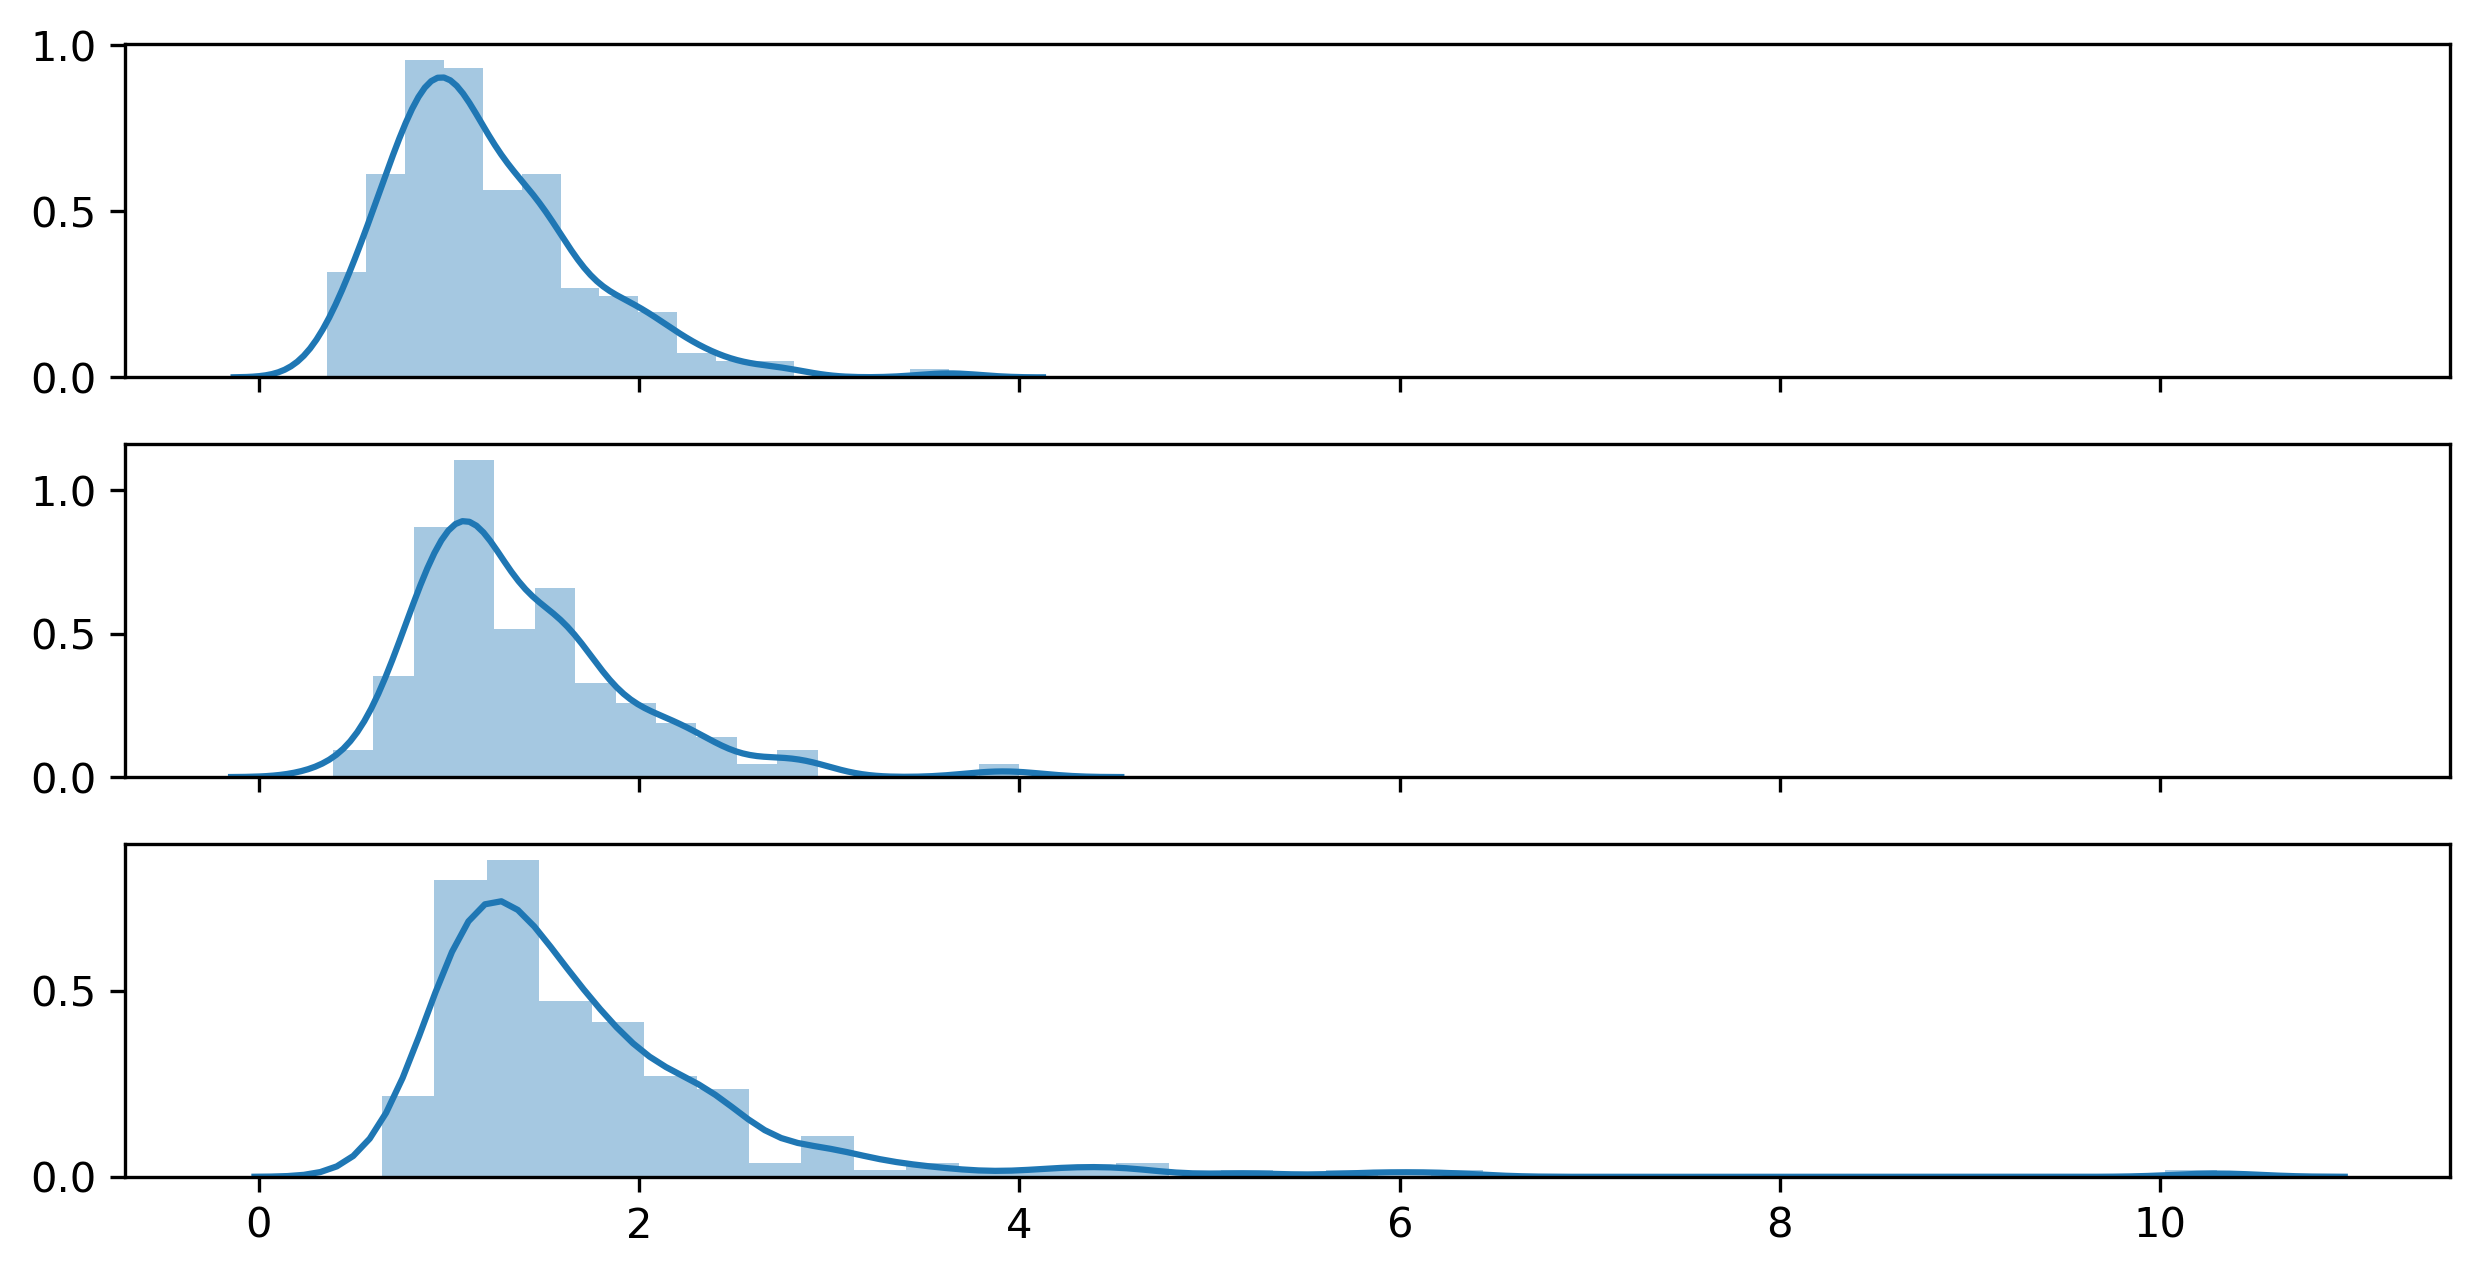

In [48]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 5), dpi=300, sharex=True)
sns.distplot(quartile1, ax=axs[0])
sns.distplot(medians,   ax=axs[1])
sns.distplot(quartile3, ax=axs[2]);

In [ ]:
test_groups.shape

In [49]:
fig, axs = plt.subplots(figsize=(50, 20), nrows=4, sharey=False, dpi=300)

lower_thresh = np.mean(quartile1) - np.std(quartile1)
upper_thresh = np.mean(quartile3) + np.std(quartile3)

for ax, position in zip(axs, range(0, len(groups), 50)):
    ax.fill_between(range(0, 52), y1=upper_thresh, y2=lower_thresh, alpha=0.1, color='r')
    ax.boxplot(condensed_matrices[position:position+50],
               showfliers=False);
    ax.set_xticklabels(groups[position:position+50], rotation=45, ha='center');
fig.tight_layout()
    
fig.savefig('chloroVScyano-sample.pdf')

In [47]:
get_std_patristic_distances('COG0499')

'COG0499'

In [ ]:
eggNOG_groups.head()

In [44]:
sahH = pkl.load(open('chloroflexi_cyano_dists/COG0499.pkl', 'rb'))

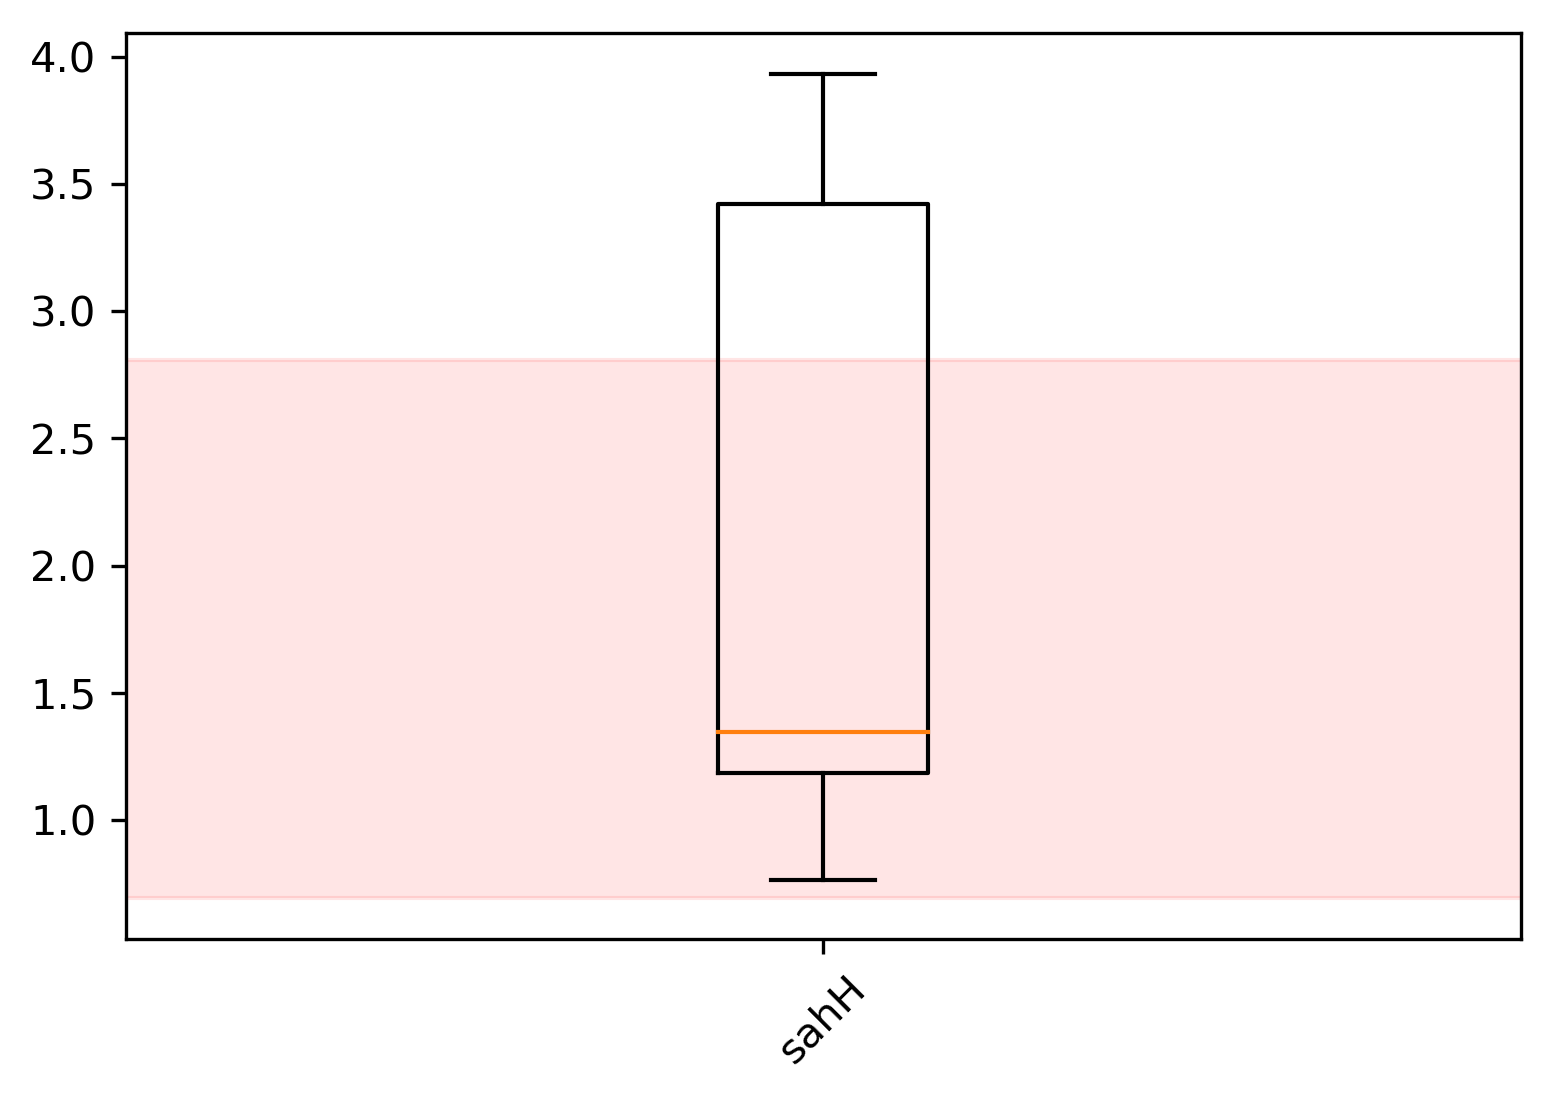

In [45]:
fig, ax = plt.subplots(dpi=300)
ax.boxplot(sahH, showfliers=False);
ax.fill_between(range(0, 3), y1=upper_thresh, y2=lower_thresh, alpha=0.1, color='r')
ax.set_xticklabels(['sahH'], rotation=45, ha='center');
fig.savefig('sahH.pdf')

In [ ]:
ax.get_xlim()

In [81]:
def visualize_in_figTree(group_id):
    tree = ete3.Tree(eggNOG_trees.loc[group_id, 'tree'], format=0)
    
    out  = open('%s.figTree' % group_id, 'w')
    out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree))
    
    for node in tree.traverse():
        if node.is_leaf():
            taxid, locus_tag = re.search('^([^.]+)\.(\S+)$', node.name, re.M).groups()
            #taxid, locus_tag = node.name.split('.')
            try:
                lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
            except ValueError:
                out.write('\t%s\n' %(node.name))
                continue
            else:
                lineage_names = ncbi.get_taxid_translator(lineage.values())

            out.write('\t%s ' %(node.name))
            comment = []
            for rank in ['class', 'phylum', 'order', 'family', 'species']:
                if rank in lineage:
                    comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
            out.write('[&%s]\n' %' '.join(comment))

    newick_text = tree.write(format=0)
    out.write(';\nend;\n')
    out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
    out.close()

In [61]:
visualize_in_figTree('COG0058')

In [82]:
candidates = '0259 1959 0075 1562 0593 3854 0351'.split()
with cd('new_candidates/'):
    for group_id in candidates:
        visualize_in_figTree('COG%s' % group_id)
    #[visualize_in_figTree('COG%s' % group_id) for group_id in candidates]

In [67]:
group_id

'0593'

In [62]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [ ]:
%%timeit
tree = ete3.Tree(eggNOG_trees.loc['COG0001', 'tree'])

leaf_names = []
for count, node in enumerate(tree.traverse()):
    if node.is_leaf():
        leaf_names.append(node.name)
    else:
        node.name = 'node_%i' % count

edges      = []
for node in tree.traverse():
    if node.is_leaf():
        continue
    for child in node.get_children():
        edges.append((node.name, child.name, child.dist))

graph  = ig.Graph.TupleList(edges=edges, directed=False, weights=True)
matrix = np.array(graph.shortest_paths(source=leaf_names, target=leaf_names, weights='weight'))
df     = pd.DataFrame(columns=leaf_names, index=leaf_names, data=matrix)

In [ ]:
tree = ete3.Tree(eggNOG_trees.loc['COG0001', 'tree'])

leaf_names = []
for count, node in enumerate(tree.traverse()):
    if node.is_leaf():
        leaf_names.append(node.name)
    else:
        node.name = 'node_%i' % count

edges      = []
for node in tree.traverse():
    if node.is_leaf():
        continue
    for child in node.get_children():
        edges.append((node.name, child.name, child.dist))

graph  = ig.Graph.TupleList(edges=edges, directed=False, weights=True)
matrix = np.array(graph.shortest_paths_dijkstra(source=leaf_names, target=leaf_names, weights='weight'))

taxids         = [int(leaf.split('.')[0]) for leaf in leaf_names]
phyla          = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

triu_indices   = np.triu_indices_from(matrix, k=1)
df = pd.DataFrame()
df['phylum1']  = phyla[triu_indices[0]]
df['phylum2']  = phyla[triu_indices[1]]
df['distance'] = matrix[triu_indices]

iiq = np.percentile(df.distance, 75) - np.percentile(df.distance, 25)
df['standardized_distance'] = (df.distance - df.distance.median()) / iiq

std_distances = df.query('(phylum1==200795 and phylum2==1117) or \
                          (phylum1==1117   and phylum2==200795)').standardized_distance

In [ ]:
%%time
tree = ete3.Tree(eggNOG_trees.loc['COG0001', 'tree'])

leaf_names = []
for count, node in enumerate(tree.traverse()):
    if node.is_leaf():
        leaf_names.append(node.name)
    else:
        node.name = 'node_%i' % count

edges      = []
for node in tree.traverse():
    if node.is_leaf():
        continue
    for child in node.get_children():
        edges.append((node.name, child.name, child.dist))

graph  = ig.Graph.TupleList(edges=edges, directed=False, weights=True)
matrix = np.array(graph.shortest_paths(source=leaf_names, target=leaf_names, weights='weight'))

taxids         = [int(leaf.split('.')[0]) for leaf in leaf_names]
phyla          = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

x = []
y = []
z = []
for (i, j), k in zip(itertools.combinations(phyla, 2), squareform(matrix, checks=False)):
    x.append(i)
    y.append(j)
    z.append(k)
    
df     = pd.DataFrame(columns=['phylum1', 'phylum2', 'distance'],
                      data    =zip(x, y, z))
iiq = np.percentile(df.distance, 75) - np.percentile(df.distance, 25)
df['standardized_distance'] = (df.distance - df.distance.median()) / iiq

std_distances = df.query('(phylum1==200795 and phylum2==1117) or \
                          (phylum2==200795 and phylum1==1117)').standardized_distance

In [ ]:
df.head()

In [ ]:
eggNOG_lineage.query('phylum==-9223372036854775808')

In [ ]:
df.query('(phylum1==200795 and phylum2==1117) or \
          (phylum2==200795 and phylum1==1117)').standardized_distance

In [ ]:
sns.distplot(df.query('(phylum1==200795 and phylum2==1117) or \
                       (phylum2==200795 and phylum1==1117)').standardized_distance)

In [ ]:
df = get_patristic_distances('2Z832')

In [ ]:
df.head()

In [ ]:
sns.distplot(df.distance)

In [ ]:
sns.distplot(df.standardized_distance)